In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od
import pandas as pd

od.download('https://www.kaggle.com/datasets/elmadafri/the-wildfire-dataset/data')

100%|██████████| 9.94G/9.94G [02:06<00:00, 84.3MB/s]


In [ ]:
import os
import numpy as np
import time
import pandas as pd

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub # pip install tensorflow_hub

In [ ]:
import os

fichier_a_supprimer ="/content/the-wildfire-dataset/the_wildfire_dataset/the_wildfire_dataset/val/fire/Both_smoke_and_fire/desktop.ini"
try:
    os.remove(fichier_a_supprimer)
except OSError as e:
    print(f'Error')

In [ ]:
train_dir='the-wildfire-dataset/the_wildfire_dataset/the_wildfire_dataset/train'
validation_dir= 'the-wildfire-dataset/the_wildfire_dataset/the_wildfire_dataset/val'
test_dir='the-wildfire-dataset/the_wildfire_dataset/the_wildfire_dataset/test'

IMG_SIZE = (224, 224)
BATCH_SIZE = 5

labels= ['Smoke_from_fires', 'Both_smoke_and_fire', 'Clean_Forest', 'Fire_confounding_elements', 'Smoke_confounding_elements']


In [ ]:
feature_extractor_layer = hub.KerasLayer(
    "https://www.kaggle.com/models/tensorflow/efficientnet/frameworks/TensorFlow2/variations/b0-classification/versions/1", input_shape=(224, 224, 3), trainable=False)

In [ ]:
import keras
img_height=224
img_width=224
batch_size=10

train = tf.keras.preprocessing.image_dataset_from_directory(
  "the-wildfire-dataset/the_wildfire_dataset/the_wildfire_dataset/train/fire",
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='categorical')

validation = tf.keras.preprocessing.image_dataset_from_directory(
  "the-wildfire-dataset/the_wildfire_dataset/the_wildfire_dataset/val/fire",
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='categorical')

test = tf.keras.preprocessing.image_dataset_from_directory(
  "the-wildfire-dataset/the_wildfire_dataset/the_wildfire_dataset/test/fire",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='categorical')

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
train = train.map(lambda x, y: (normalization_layer(x), y))
validation=validation.map(lambda x, y: (normalization_layer(x), y))
test=test.map(lambda x, y: (normalization_layer(x), y))

model_fire = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(2)
])
model_fire.summary()
model_fire.compile(
  optimizer=tf.keras.optimizers.legacy.Adam(),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'])
tensorboard_logdir = os.path.join(os.getcwd(),'logs','tensorboard') # Let's log Tensorboard data to this folder
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=tensorboard_logdir) # Create a Tensorboard "callback"
model_fire.fit(train, epochs=4,validation_data=validation,
                    callbacks=[tensorboard_callback])


feature_extractor_layer.trainable = True
model_fire.compile(optimizer=keras.optimizers.legacy.Adam(1e-3),  # Very low learning rate
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['acc'])
model_fire.fit(train, epochs=10,validation_data=validation,
                    callbacks=[tensorboard_callback])
model_fire.evaluate(test)

Found 730 files belonging to 2 classes.
Found 156 files belonging to 2 classes.
Found 159 files belonging to 2 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1000)              5330564   
                                                                 
 dense (Dense)               (None, 2)                 2002      
                                                                 
Total params: 5332566 (20.34 MB)
Trainable params: 2002 (7.82 KB)
Non-trainable params: 5330564 (20.33 MB)
_________________________________________________________________
Epoch 1/4
73/73 [==============================] - 124s 1s/step - loss: 0.6808 - acc: 0.6192 - val_loss: 0.6674 - val_acc: 0.6346
Epoch 2/4
73/73 [==============================] - 94s 1s/step - loss: 0.6623 - acc: 0.6315 - val_loss: 0.6512 - val_acc: 0.6346
Epoch 3/4
73/73 [===============

[0.5347999930381775, 0.8616352081298828]

In [ ]:
import flatbuffers
# Convert the model (note: we are converting the model directly from the "model" variable)
converter = tf.lite.TFLiteConverter.from_keras_model(model_fire)

tflite_model = converter.convert()
print(1)
# Let's save the model as "model_2.tflite"
tflite_model2_path = os.path.join(os.getcwd(),'model_fire1.tflite')
with open(tflite_model2_path, 'wb') as f:
  f.write(tflite_model)

1


In [ ]:
test_ = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir+"/fire",
  image_size=(img_height, img_width),
  batch_size=1,label_mode='categorical',shuffle=False)
test_=test_.map(lambda x, y: (normalization_layer(x), y))

Found 159 files belonging to 2 classes.


In [ ]:
pred=model_fire.predict(test_)
predictions=np.argmax(pred,axis=-1)

159/159 [==============================] - 18s 114ms/step


In [ ]:
predictions

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1])

In [ ]:
true_class=[]
for images,labels_ in test_:
  for i in range(len(labels_)):
    true_class+=[np.flatnonzero(labels_[i] == 1)[0]]
true_class=np.array(true_class)
true_class

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1])

In [ ]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

matrice_confusion = confusion_matrix(true_class, predictions)

# Afficher la matrice de confusion
print("Matrice de confusion :")
print(matrice_confusion)

# Afficher le rapport de classification
rapport_classification = classification_report(true_class, predictions)
print("Rapport de classification :")
print(rapport_classification)

Matrice de confusion :
[[50  9]
 [13 87]]
Rapport de classification :
              precision    recall  f1-score   support

           0       0.79      0.85      0.82        59
           1       0.91      0.87      0.89       100

    accuracy                           0.86       159
   macro avg       0.85      0.86      0.85       159
weighted avg       0.86      0.86      0.86       159



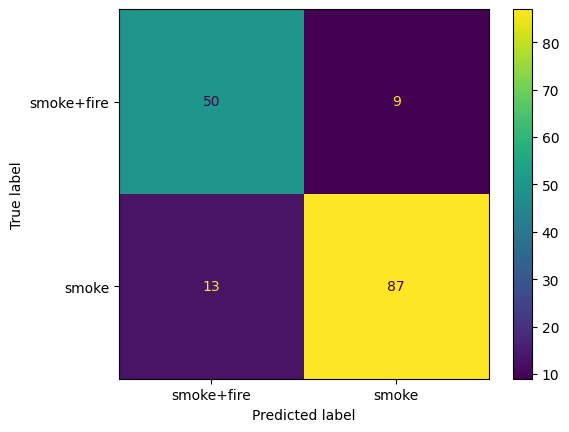

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

disp=ConfusionMatrixDisplay(matrice_confusion,display_labels=["smoke+fire","smoke"])
disp.plot()
plt.show()

In [ ]:
feature_extractor_layer = hub.KerasLayer(
    "https://www.kaggle.com/models/tensorflow/efficientnet/frameworks/TensorFlow2/variations/b0-classification/versions/1", input_shape=(224, 224, 3), trainable=False)

In [ ]:
import keras
img_height=224
img_width=224
batch_size=15

train = tf.keras.preprocessing.image_dataset_from_directory(
  "the-wildfire-dataset/the_wildfire_dataset/the_wildfire_dataset/train/nofire",
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='categorical')

validation = tf.keras.preprocessing.image_dataset_from_directory(
  "the-wildfire-dataset/the_wildfire_dataset/the_wildfire_dataset/val/nofire",
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='categorical')

test = tf.keras.preprocessing.image_dataset_from_directory(
  "the-wildfire-dataset/the_wildfire_dataset/the_wildfire_dataset/test/nofire",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='categorical')

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
train = train.map(lambda x, y: (normalization_layer(x), y))
validation=validation.map(lambda x, y: (normalization_layer(x), y))
test=test.map(lambda x, y: (normalization_layer(x), y))

model_nofire = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(3)
])
model_nofire.summary()
model_nofire.compile(
  optimizer=tf.keras.optimizers.legacy.Adam(),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'])
tensorboard_logdir = os.path.join(os.getcwd(),'logs','tensorboard') # Let's log Tensorboard data to this folder
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=tensorboard_logdir) # Create a Tensorboard "callback"
model_nofire.fit(train, epochs=4,validation_data=validation,
                    callbacks=[tensorboard_callback])


feature_extractor_layer.trainable = True
model_nofire.compile(optimizer=keras.optimizers.legacy.Adam(1e-3),  # Very low learning rate
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['acc'])
model_nofire.fit(train, epochs=10,validation_data=validation,
                    callbacks=[tensorboard_callback])
model_nofire.evaluate(test)

Found 1157 files belonging to 3 classes.
Found 246 files belonging to 3 classes.
Found 251 files belonging to 3 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1000)              5330564   
                                                                 
 dense (Dense)               (None, 3)                 3003      
                                                                 
Total params: 5333567 (20.35 MB)
Trainable params: 3003 (11.73 KB)
Non-trainable params: 5330564 (20.33 MB)
_________________________________________________________________
Epoch 1/4
78/78 [==============================] - 475s 5s/step - loss: 1.0788 - acc: 0.5220 - val_loss: 1.0588 - val_acc: 0.5244
Epoch 2/4
78/78 [==============================] - 446s 5s/step - loss: 1.0485 - acc: 0.5281 - val_loss: 1.0329 - val_acc: 0.5163
Epoch 3/4
78/78 [============

[0.806189775466919, 0.7928286790847778]

In [ ]:
import flatbuffers
# Convert the model (note: we are converting the model directly from the "model" variable)
converter = tf.lite.TFLiteConverter.from_keras_model(model_nofire)

tflite_model = converter.convert()
print(1)
# Let's save the model as "model_2.tflite"
tflite_model2_path = os.path.join(os.getcwd(),'model_fire2.tflite')
with open(tflite_model2_path, 'wb') as f:
  f.write(tflite_model)

1


In [ ]:
test_ = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir+"/nofire",
  image_size=(img_height, img_width),
  batch_size=1,label_mode='categorical',shuffle=False)
test_=test_.map(lambda x, y: (normalization_layer(x), y))

Found 251 files belonging to 3 classes.


In [ ]:
pred_no=model_nofire.predict(test_)
predictions_no=np.argmax(pred,axis=-1)

251/251 [==============================] - 47s 182ms/step


In [ ]:
predictions_no

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 1, 2, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 1, 1, 0, 2, 2,
       2, 1, 2, 0, 2, 2, 0, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 1, 2, 1,
       2, 2, 0, 2, 2, 1, 2, 2, 2, 0, 2, 2, 2, 1, 2, 2, 2, 2, 0, 2, 2, 2,
       2, 1, 1, 2, 2, 2, 2, 2, 2])

In [ ]:
true_class_no=[]
for images,labels_ in test_:
  for i in range(len(labels_)):
    true_class_no+=[np. (labels_[i] == 1)[0]]
true_cltrue_class_noass=np.array(true_class)


[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,


In [ ]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

matrice_confusion_no = confusion_matrix(true_class_no, predictions_no)

# Afficher la matrice de confusion
print("Matrice de confusion :")
print(matrice_confusion_no)

# Afficher le rapport de classification
rapport_classification_no = classification_report(true_class_no, predictions_no)
print("Rapport de classification :")
print(rapport_classification_no)

Matrice de confusion :
[[ 43   8   1]
 [ 15 106   7]
 [  8  12  51]]
Rapport de classification :
              precision    recall  f1-score   support

           0       0.65      0.83      0.73        52
           1       0.84      0.83      0.83       128
           2       0.86      0.72      0.78        71

    accuracy                           0.80       251
   macro avg       0.79      0.79      0.78       251
weighted avg       0.81      0.80      0.80       251



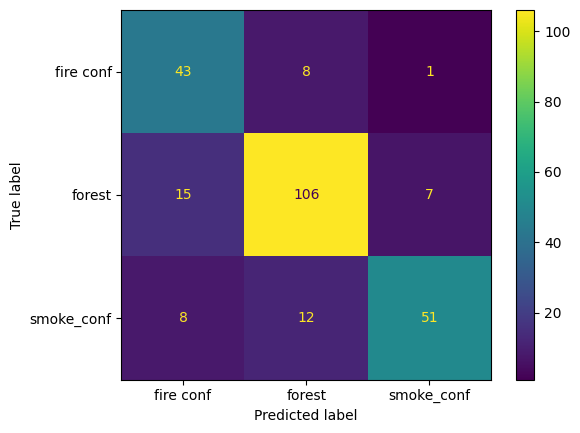

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

disp=ConfusionMatrixDisplay(matrice_confusion_no,display_labels=["fire conf","forest","smoke_conf"])
disp.plot()
plt.show()

In [ ]:
# Load the TFLite model and allocate tensors.
# Let's load the TFLite model we saved to "./saved_tflite_models/model_2.tflite" above.
model_complexity=0
interpreter = tf.lite.Interpreter(model_path="model_fire.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()


NameError: ignored

In [ ]:
import tensorflow as tf
test = tf.keras.preprocessing.image_dataset_from_directory(
  "the-wildfire-dataset/the_wildfire_dataset/the_wildfire_dataset/test",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='categorical')
# Sélectionner les indices des exemples pour chaque classe
indices_class_0 = tf.where(predictions_model1[:, 0] > seuil)[:, 0]
indices_class_1 = tf.where(predictions_model1[:, 1] > seuil)[:, 0]

# Créer des datasets pour chaque classe
dataset_class_0 = tf.gather(dataset, indices_class_0)
dataset_class_1 = tf.gather(dataset, indices_class_1)
